In [1]:
import pandas as pd
import numpy as np
import pickle
from panelsplit.cross_validation import PanelSplit
from panelsplit.application import cross_val_fit_predict
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import PrecisionRecallDisplay, mean_absolute_error, RocCurveDisplay
from dbx_config import cf_dbx_helper
import utils as u
from params import shift_amount, ends, directory_forecasts, directory_models, today, split_size
print("Today's date:", today)

Today's date: 20250326


## 1) Load Conflict Data from Dropbox

In [2]:
df_merge_last = cf_dbx_helper.read_csv(cf_dbx_helper.output_path, "04_merge", "df_merge_last.csv")
df_merge_last

,updated,isocode,period,pr_topic_0,pr_topic_1,pr_topic_2,pr_topic_3,pr_topic_4,pr_topic_5,pr_topic_6,...,int_best_12_naive,int_best_03_naive,int_best_12,int_best_03,weights,lnbest,int_lnbest_12_naive,int_lnbest_03_naive,int_lnbest_12,int_lnbest_03
0,202502,AFG,198901,0.005265,0.047252,0.215465,0.020685,0.066201,0.025888,0.147775,...,8568.0,2142.0,4722.0,2398.0,0.333333,6.572283,9.055906,7.669962,8.460199,7.782807
1,202502,AFG,198902,0.004409,0.031220,0.193954,0.029034,0.073656,0.025634,0.156494,...,5244.0,1311.0,4616.0,2692.0,0.333333,5.081404,8.565031,7.179308,8.437500,7.898411
2,202502,AFG,198903,0.005437,0.019389,0.252812,0.018150,0.082697,0.017100,0.124449,...,10472.0,2618.0,3021.0,1443.0,0.333333,7.464510,9.256556,7.870548,8.013674,7.275172
3,202502,AFG,198904,0.006366,0.018804,0.251504,0.016181,0.080563,0.021914,0.101301,...,9336.0,2398.0,3016.0,1569.0,0.333333,6.204558,9.141740,7.782807,8.012018,7.358831
4,202502,AFG,198905,0.003449,0.018526,0.239509,0.024314,0.089422,0.014762,0.096135,...,8558.4,2692.0,2570.0,1525.0,0.333333,6.120297,9.054785,7.898411,7.852050,7.330405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82777,202502,ZWE,202410,0.084123,0.225327,0.064704,0.040629,0.010744,0.049475,0.137299,...,0.0,0.0,NaN,0.0,1.000000,0.000000,0.000000,0.000000,NaN,0.000000
82778,202502,ZWE,202411,0.199806,0.124206,0.007235,0.033751,0.010906,0.044168,0.062044,...,0.0,0.0,NaN,0.0,1.000000,0.000000,0.000000,0.000000,NaN,0.000000
82779,202502,ZWE,202412,0.190719,0.051637,0.008268,0.050734,0.002755,0.021173,0.106243,...,0.0,0.0,NaN,NaN,1.000000,0.000000,0.000000,0.000000,NaN,NaN
82780,202502,ZWE,202501,0.047320,0.068893,0.047722,0.005239,0.005239,0.008418,0.038718,...,0.0,0.0,NaN,NaN,1.000000,0.000000,0.000000,0.000000,NaN,NaN


## 2) Prepare target and features

In [3]:
# Compute log transformation
# ==============================================================================
df = df_merge_last.copy()
df['log_best'] = np.log1p(df['best'])  # np.log1p(x) = log(x + 1), numerically stable

# Select relevant columns
# ==============================================================================
id_cols = ['isocode', 'period']
stock_cols = [col for col in df.columns if "stock" in col]
keep_cols = id_cols + ['log_best', 'population'] + stock_cols
df = df[keep_cols]
df = df.sort_values(['isocode', 'period']).set_index(['isocode', 'period'])

# Lag stock variables by specified amount
# ==============================================================================
for col in stock_cols:
    df[col] = df.groupby(level='isocode')[col].shift(shift_amount)

# Compute rolling means of log_best 
# ==============================================================================
for r in ends:
    colname = f'log_best_past_{r}'
    df[colname] = (
        df.groupby(level='isocode')['log_best']
        .transform(lambda x: x.shift(shift_amount + 1).rolling(window=r, min_periods=1).mean())
    )
df = df.reset_index()
df

,isocode,period,log_best,population,stock_tokens,stock_topic_0,stock_topic_1,stock_topic_2,stock_topic_3,stock_topic_4,...,stock_topic_10,stock_topic_11,stock_topic_12,stock_topic_13,stock_topic_14,log_best_past_3,log_best_past_6,log_best_past_12,log_best_past_24,log_best_past_60
0,AFG,198901,6.572283,11726646.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,198902,5.081404,11755987.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,198903,7.464510,11785402.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,198904,6.204558,11814890.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,198905,6.120297,11844452.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82777,ZWE,202410,0.000000,16710874.0,12411.022870,0.091139,0.101106,0.010160,0.076981,0.010335,...,0.182823,0.041137,0.100343,0.059359,0.073512,0.0,0.0,0.0,0.0,0.078036
82778,ZWE,202411,0.000000,16734432.0,12211.818296,0.074855,0.092323,0.009187,0.097159,0.008994,...,0.181302,0.044687,0.105333,0.055308,0.070526,0.0,0.0,0.0,0.0,0.078036
82779,ZWE,202412,0.000000,16758031.0,11906.454637,0.062456,0.088314,0.010115,0.098329,0.007752,...,0.172350,0.042467,0.104877,0.064719,0.072251,0.0,0.0,0.0,0.0,0.078036
82780,ZWE,202501,0.000000,16781670.0,11797.163709,0.051469,0.077737,0.011047,0.126166,0.006647,...,0.163220,0.043644,0.103598,0.056264,0.078867,0.0,0.0,0.0,0.0,0.078036


In [4]:
target = "log_best"
stock_cols = df.columns[df.columns.str.contains("stock")].tolist()
past_cols = df.columns[df.columns.str.contains("log_best_past")].tolist()

features = (stock_cols + past_cols + ["population"])
df.dropna(subset=features + [target], inplace=True)

max_year = int(str(df["period"].max())[:4])
n_splits = (max_year - 1995 + 1) * 12
n_splits = int(n_splits / split_size)
print(f"Number of splits: {n_splits}")

Number of splits: 10


In [5]:
model_params = {}

classifier = RandomForestRegressor(n_jobs=-1, random_state=1, **model_params)
ps = PanelSplit(periods=df.period, n_splits=n_splits, test_size=split_size)
splits = ps.split()

#for train_idx, test_idx in splits[0:1]:
#    print("Train:"); display(df.loc[train_idx]) 
#    print("Test:"); display(df.loc[test_idx])

In [6]:
# Generate predictions
df_mask = ps.gen_test_labels(df[id_cols + [target]])
df_mask["log_best_hat"], fitted_classifiers = cross_val_fit_predict(estimator=classifier, 
                                                    X=df[features], 
                                                    y=df[target], 
                                                    cv=ps,
                                                    n_jobs=-1)
# Store classifier
filename = f"{directory_models}/rf_regressor_{today}.pkl"
with open(filename, "wb") as handle:
    pickle.dump(fitted_classifiers, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Store predictions
filename = f"{directory_forecasts}/rf_regressor_{today}.csv"
df_mask.to_csv(filename, index=False)

<Axes: >

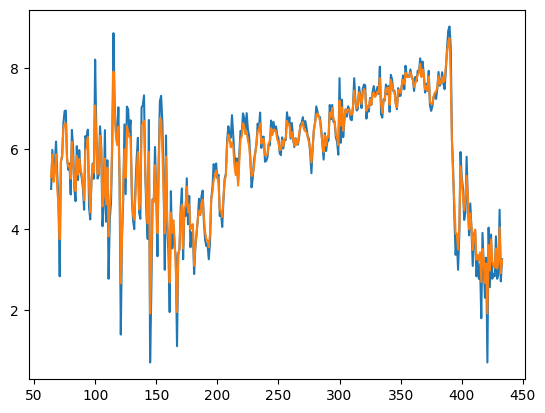

In [7]:
isocode = "AFG"
df_mask[df_mask["isocode"] == isocode]["log_best"].plot()
df_mask[df_mask["isocode"] == isocode]["log_best_hat"].plot()